In [2]:
import smuthi


********************************
    SMUTHI version 2.1.2
********************************
Starting simulation.
Number of unknowns: 108
Initial field coefficients: 100%|##########| elapsed: 00:00 remaining: 00:00
T-matrices                : 100%|##########| elapsed: 00:00 remaining: 00:00
Explicit coupling matrix computation on CPU.
Coupling matrix memory footprint: 186.6KB
Particle coupling matrix  : 100%|##########| elapsed: 00:00 remaining: 00:00
Solve (LU decomposition)  : ... done

Evaluate fields ...
Scatt. field expansion (0): 100%|██████████| elapsed: 00:00 remaining: 00:00
Scatt. field expansion (1): 100%|██████████| elapsed: 00:00 remaining: 00:00
Scatt. field expansion (2): 100%|██████████| elapsed: 00:00 remaining: 00:00
Compute scatt. near-field : 100%|██████████| elapsed: 00:07 remaining: 00:00
Compute initl. near-field : 100%|██████████| elapsed: 00:00 remaining: 00:00
Compute intrn. near-field : 100%|██████████| elapsed: 00:00 remaining: 00:00
Generate plots ...
Skippi

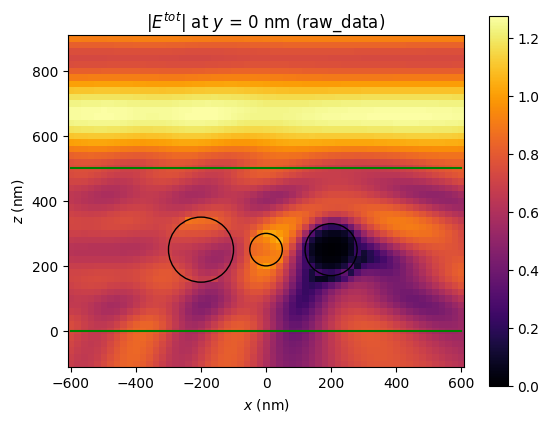

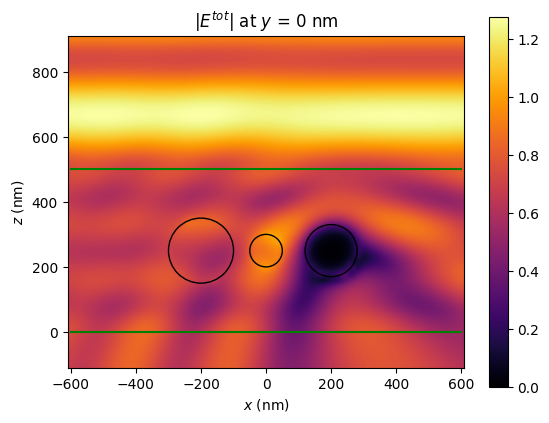

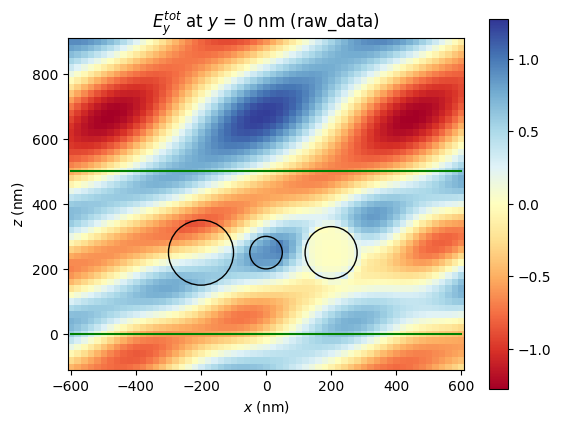

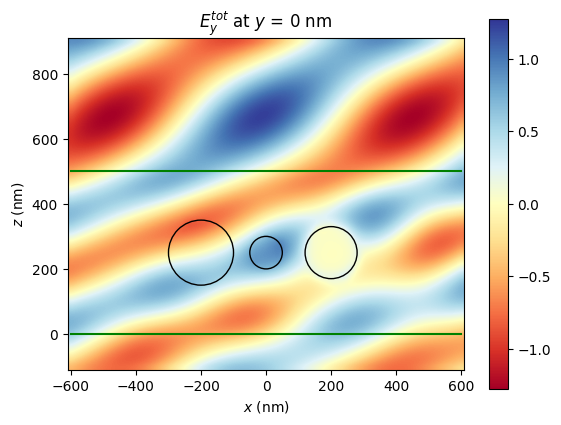

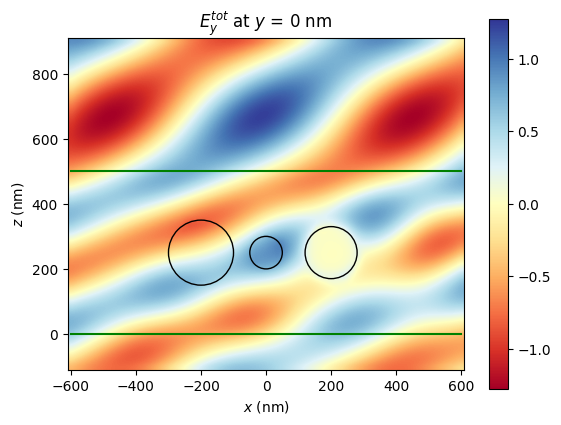

In [1]:
import numpy as np
import smuthi.simulation
import smuthi.initial_field
import smuthi.layers
import smuthi.particles
import smuthi.postprocessing.graphical_output as go
import smuthi.utility.cuda

# Initialize the layer system object containing
# - a substrate (glass)
# - a titania layer
# - the ambient (air)
# The coordinate system is such that the interface
# between the first two layers defines the plane z=0.
# Note that semi infinite layers have thickness 0!
three_layers = smuthi.layers.LayerSystem(thicknesses=[0, 500, 0],
                                         refractive_indices=[1.52, 1.75, 1])

# Scattering particles, immersed in the titania layer
sphere1 = smuthi.particles.Sphere(position=[-200, 0, 250],
                                  refractive_index=1.52,    # glass sphere
                                  radius=100,
                                  l_max=3)

sphere2 = smuthi.particles.Sphere(position=[0, 0, 250],
                                  refractive_index=1,       # air bubble
                                  radius=50,
                                  l_max=3)

sphere3 = smuthi.particles.Sphere(position=[200, 0, 250],
                                  refractive_index=1+6j,    # metal sphere
                                  radius=80,
                                  l_max=4)


# List of all scattering particles
three_spheres = [sphere1, sphere2, sphere3]

# Initial field
plane_wave = smuthi.initial_field.PlaneWave(vacuum_wavelength=550,
                                            polar_angle= 4*np.pi/5, # from top
                                            azimuthal_angle=0,
                                            polarization=0)         # 0=TE 1=TM

# Initialize and run simulation
simulation = smuthi.simulation.Simulation(layer_system=three_layers,
                                          particle_list=three_spheres,
                                          initial_field=plane_wave,
                                          length_unit='nm')
simulation.run()

# Create plots that visualize the electric near field.

go.show_near_field(quantities_to_plot=['norm(E)', 'E_y'],
                   show_plots=True,
                   show_opts=[{'label':'raw_data'},
                              {'interpolation':'quadric'},
                              {'interpolation':'quadric'}],
                   save_plots=True,
                   save_opts=[{'format':'png'},
                              {'format':'pdf','dpi':200},
                              {'format':'gif'}], # animated gif of E_y
                   outputdir='./output',
                   xmin=-600,
                   xmax=600,
                   zmin=-100,
                   zmax=900,
                   resolution_step=20,
                   simulation=simulation,
                   show_internal_field=True)


# If you want to plot data with a logarithmic colorbar, use the 'norm' key of the
# show_opts dictionary to pass e.g., a LogNorm() or a SymLogNorm(). For example:

# from matplotlib import colors
#
# colorlog = colors.SymLogNorm(base=10, linthresh=3, linscale=2, vmin=-1000, vmax=1000)
# go.show_near_field(simulation=simulation,
#                    quantities_to_plot=["E_z"],
#                    show_opts=[{'label': 'raw_log', 'norm': colorlog},
#                               {'label': 'raw', 'vmax': 1e2}]
#                    ... )